In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from TwitterAPI import TwitterAPI
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
from sklearn.utils import shuffle
from nltk.corpus import stopwords
plt.rcParams['figure.figsize']=(12.0,4.0)

In [2]:
api = TwitterAPI(consumer_key='XrJHIZzeveP06K992nXShtUXS',
                        consumer_secret='kZl0F2ghB8ecqI1PK6NjV5tKW4szTNW5bnyDmeuCKHF6Gbdttd',
                        access_token_key='1295434260514402307-pq7jzeDl1j8piM3Bpqo1Y1HoFXRCEQ',
                        access_token_secret='Gqks3ZhgD45YTYAkaqLQBUjblkPfGDjhJbgjnXG3jUz0r')


In [80]:
df=pd.read_csv(r"dataset\train_data_full.csv",encoding="ISO-8859-1",header=None)
df = shuffle(df)

df = df.sample(frac=0.00625).reset_index(drop=True)

In [82]:
len(df[df[0]==2])

0

In [83]:
def class_imbalance(dataset,threshold,target='Polarity',num_classes=2):
    c=[]
    l=dataset[target].count()/num_classes
    print("Ideal class size : ",l)
    for i in range(num_classes):
        k=np.array(dataset[dataset[target]==4*i])
        
        c.append(len(k))
        print("Length of class",i,": ",c[i])
        if (1-threshold)*l<c[i]<(1+threshold)*l:
            continue;
            
        else:
            print('There exists a Class Imbalance in your Dataset')
            return True
            break;
    return False

In [84]:
df.columns=['Polarity','ID','Date','Query','USER_ID','Tweet']
df.head()

,Polarity,ID,Date,Query,USER_ID,Tweet
0,4,1557400428,Sun Apr 19 03:53:12 PDT 2009,NO_QUERY,Kalediscope,"@Hollywoodheat lol at least u know, gotta love..."
1,4,2063137861,Sun Jun 07 01:30:21 PDT 2009,NO_QUERY,bellzaa,she cracks me up and then the fat wig said to...
2,0,2259699723,Sat Jun 20 18:01:07 PDT 2009,NO_QUERY,oliiix3,i wanted jordin sparks to sing Battlefield
3,4,2174568133,Sun Jun 14 22:49:44 PDT 2009,NO_QUERY,stalkerh,"Good Morning All , traffic was so nice today"
4,4,1550968445,Sat Apr 18 07:46:36 PDT 2009,NO_QUERY,Danijelo,@MCHammer they dont show live-baseball in germ...


In [85]:
class_imbalance(df,threshold=0.05)

Ideal class size :  5000.0
Length of class 0 :  4959
Length of class 1 :  5041


False

In [123]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA
sia=SIA()
def sentiment_analyzer_scores(sentence):
    score = sia.polarity_scores(sentence)
    print("{} {}".format(sentence, score))
    return score

In [110]:
len(np.array(df[df['Polarity']==0]))

4959

## What is the format of the training data?
The data is a CSV with emoticons removed. Data file format has 6 fields:

0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

1 - the id of the tweet (2087)

2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)

3 - the query (lyx). If there is no query, then this value is NO_QUERY.

4 - the user that tweeted (robotickilldozr)

5 - the text of the tweet (Lyx is cool)


Since we do not need the user_id,date,query, and tweet id, we can proceed to delete this columns

In [87]:
drop=['ID', 'Date', 'Query', 'USER_ID']
df.drop(drop,axis=1,inplace=True)
df.head()

,Polarity,Tweet
0,4,"@Hollywoodheat lol at least u know, gotta love..."
1,4,she cracks me up and then the fat wig said to...
2,0,i wanted jordin sparks to sing Battlefield
3,4,"Good Morning All , traffic was so nice today"
4,4,@MCHammer they dont show live-baseball in germ...


In [88]:
import re
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords

class PreProcessTweets:
    
    def __init__(self):
        self._stopwords=set(stopwords.words('english')+list(punctuation)+['AT_USER','URL'])

    def pre_processTweet(self,tweet):
        tweet=tweet.lower()  #to convert the text to lower case
        tweet=re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet) #to remove URLs
        tweet=re.sub('@[^\s]+','AT_USER',tweet) #to remove usernames
        tweet=re.sub('#([^\s]+)','\1',tweet)# to remove the hashtag
        
        
        return tweet    
        
    def processTweets(self,list_of_tweets):
        processedTweets=[]
        for tweet in list_of_tweets:
            tweet = self.pre_processTweet(tweet)
            processedTweets.append(tweet)
        return processedTweets

In [89]:
preprocess=PreProcessTweets()
pre_df=preprocess.processTweets(df['Tweet'])
pre_df=pd.DataFrame(pre_df)
pre_df=pd.concat([pre_df,df['Polarity']],axis=1)
pre_df.columns=['Tweet','Polarity']
pre_df.head()

,Tweet,Polarity
0,"AT_USER lol at least u know, gotta love grandm...",4
1,she cracks me up and then the fat wig said to...,4
2,i wanted jordin sparks to sing battlefield,0
3,"good morning all , traffic was so nice today",4
4,AT_USER they dont show live-baseball in german...,4


In [90]:
def clean_text(x):
  
  tw=['AT_USER','URL']

  text=[word for word in x.split() if word not in tw ]
  text=" ".join(text)

  return text

In [91]:
pre_df['cleaned']=pre_df['Tweet'].apply(lambda x: clean_text(x))

check for class imbalance

cross validatoin, check each set is training and val set is class balanced

## Data Exploration


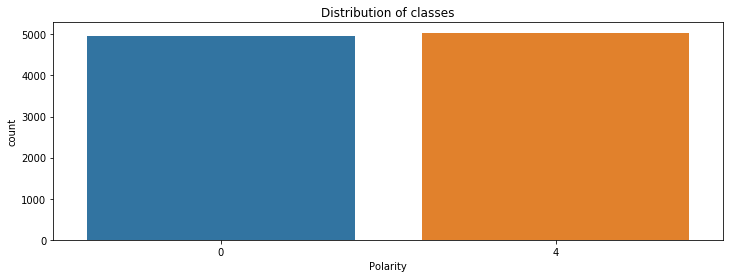

In [92]:

sns.countplot(x='Polarity',data=pre_df);
plt.title("Distribution of classes");

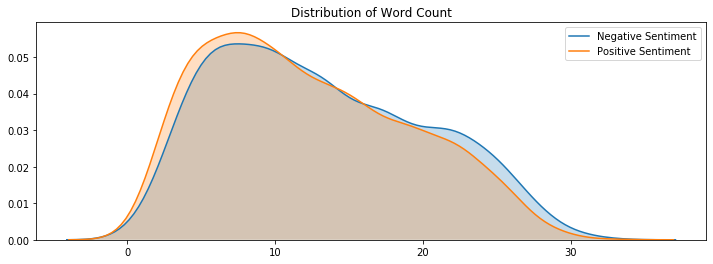

In [93]:
#distribution of number of words in tweet
pre_df['word_count']=pre_df['cleaned'].apply(lambda x: len(x.split()))

sns.kdeplot(pre_df['word_count'][pre_df['Polarity']==0],shade=True,label='Negative Sentiment');
sns.kdeplot(pre_df['word_count'][pre_df['Polarity']==2],shade=True,label='Neutral Sentiment');
sns.kdeplot(pre_df['word_count'][pre_df['Polarity']==4],shade=True,label='Positive Sentiment');

plt.title('Distribution of Word Count');
plt.show()

In [94]:
pre_df[pre_df["word_count"]==30].count()

Tweet         18
Polarity      18
cleaned       18
word_count    18
dtype: int64

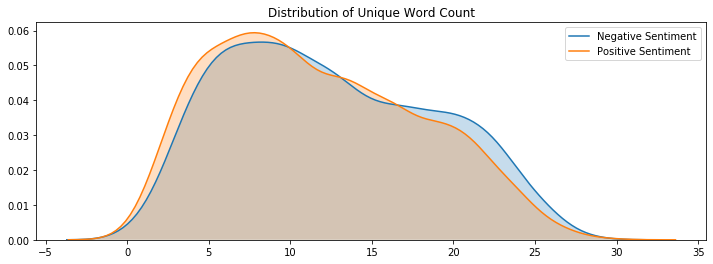

In [95]:
#distribution of number of words in tweet
pre_df['unique_word_count']=pre_df['cleaned'].apply(lambda x: len(set(x.split())))

sns.kdeplot(pre_df['unique_word_count'][pre_df['Polarity']==0],shade=True,label='Negative Sentiment');
sns.kdeplot(pre_df['unique_word_count'][pre_df['Polarity']==2],shade=True,label='Neutral Sentiment');
sns.kdeplot(pre_df['unique_word_count'][pre_df['Polarity']==4],shade=True,label='Positive Sentiment');

plt.title('Distribution of Unique Word Count');
plt.show()

C:\Users\Public\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


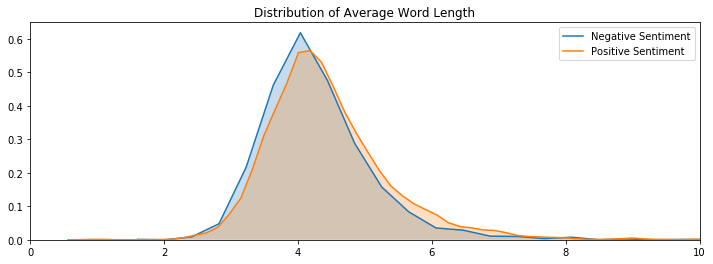

In [96]:

#Distribution of average word count
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

pre_df['average_word_length']=pre_df['cleaned'].apply(lambda x: average_word_length(x))

sns.kdeplot(pre_df['average_word_length'][pre_df['Polarity']==0],shade=True,label='Negative Sentiment');
sns.kdeplot(pre_df['average_word_length'][pre_df['Polarity']==2],shade=True,label='Neutral Sentiment');
sns.kdeplot(pre_df['average_word_length'][pre_df['Polarity']==4],shade=True,label='Positive Sentiment');
plt.xlim(0,10)

plt.title('Distribution of Average Word Length');
plt.show()

## Data Cleaning


In [97]:

def clean(tweet):
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    return tweet

In [98]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [99]:

stopword=set(stopwords.words('english'))
stopword=stopword.union(set(punctuation))
lemmatizer=WordNetLemmatizer()


def lemmatize(text):
    text=word_tokenize(text)
    tagged=nltk.pos_tag(text)
    string=[]
    
    for index,word in enumerate(text):
        if word not in stopword:
            word=lemmatizer.lemmatize(word,pos=get_wordnet_pos(tagged[index][1]))
            string.append(word)
    string=" ".join(string)
    return string

In [100]:
pre_df['cleaned']=pre_df['cleaned'].apply(lambda x: clean(x))
pre_df['lemma']=pre_df['cleaned'].apply(lambda x: lemmatize(x))


In [101]:
pre_df.columns

Index(['Tweet', 'Polarity', 'cleaned', 'word_count', 'unique_word_count',
       'average_word_length', 'lemma'],
      dtype='object')

In [102]:
drop1=['Tweet','cleaned','word_count','unique_word_count',
       'average_word_length']
clean_df=pre_df.drop(drop1,axis=1)

In [103]:
clean_df.to_csv('Lemmatized_text')

In [26]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer


token=RegexpTokenizer(r'[a-zA-Z0-9]+')
tfidf=TfidfVectorizer(stop_words='english',tokenizer=token.tokenize)
text=tfidf.fit_transform(clean_df['lemma'])


## Model 

In [27]:
def model_class_imbalance(label,threshold,num_classes=2):
    c=[]
    
    l=len(label)/num_classes
    print("**********************************")
    print("Ideal class size : ",l)
    for i in range(num_classes):
        
        k=label[label==4*i].count()
        c.append(k)
        
        print("Length of class",i,": ",c[i])
        if (1-threshold)*l<c[i]<(1+threshold)*l:
            continue;
            
        else:
            print('There exists a Class Imbalance in your Dataset')
            return True
            break;
    return False
        

In [ ]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(text,clean_df['Polarity'],test_size=0.2,shuffle=True)
while model_class_imbalance(y_train,threshold=0.05) or model_class_imbalance(y_test,0.05)==True:
    x_train,x_test,y_train,y_test=train_test_split(text,clean_df['Polarity'],test_size=0.2,shuffle=True)

In [ ]:
from sklearn import metrics
clf1=MultinomialNB()
%time clf1.fit(x_train,y_train)
ypred1=clf1.predict(x_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, ypred1))

In [ ]:

%time clf3 = BernoulliNB().fit(x_train,y_train)
ypred3= clf3.predict(x_test)
print("BernoulliNB Accuracy:",metrics.accuracy_score(y_test,ypred3))